To do:<br>
-Correct for proper motions<br>
-Other images than DSS (e.g., SDSS, SkyMapper)<br>
-Get the lk aperture to work automatically on the overlay<br>
-Better lognorm scaling<br>

- astropy
- astroquery
- k2flix
- ipython 
- reproject
- lightkurve

In [322]:
import os
import numpy as np
import requests
import k2flix
import matplotlib.ticker as ticker

from astroquery.mast import Tesscut
from astroquery.mast import Catalogs
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm

import lightkurve as lk

import matplotlib.pyplot as plt
from reproject import reproject_interp
import matplotlib.gridspec as gs
from matplotlib.colors import LogNorm

from IPython.display import Image
from ipywidgets import interact, interactive, fixed, interact_manual

import cv2

%matplotlib inline


In [ ]:
pixelsize = 11

# select a target and cutout size in pixels
ra, dec = 186.7679384635554, -72.4518042663561 
ra, dec = 61.331654, 20.157032

target_x = 217
target_y = 1940

target = '{0}, {1}'.format(ra, dec)
x = y = pixelsize ## pixel size
# set local file path to current working directory
path = os.path.abspath(os.path.curdir)

In [5]:
cutout_coords = SkyCoord(ra, dec, unit="deg")
try:
    table = Tesscut.download_cutouts(cutout_coords, size=x, path=path)
except Exception as e:
    print('Error: Could not download cutouts: {0}'.format(e))
else:
    print(table)
    files = table['Local Path']

Local Path
----------


In [6]:
files = ['s0043/cam3-ccd2/hlsp_tica_tess_ffi_s0043-o1-00180084-cam3-ccd2_tess_v01_img.fits']

In [118]:
# grab the first file in the list
filename = files[0] ## so 1227 has 3 sectors of data, I just manually selected sector 11 as the first one. 
hdu = fits.open(filename)

#tpf = k2flix.TargetPixelFile(filename)
n_pix = hdu[0].data.shape[0]
res = 21.0 * (u.arcsec/u.pixel) ## I think it's actually 20.98 or something. This is fine. 
area = res * (n_pix * u.pixel)
d = area.to(u.degree)
fov = d.value 

# compute the wcs of the image
wcs = WCS(hdu[0].header)#tpf.hdulist['APERTURE'].header)

# check to make sure I didn't do something stupid.
print('filename', filename)
print('Target TPF', target)
print('Field of View [degrees]', fov)
print('Number pixels', hdu[0].data.shape[0])

filename s0043/cam3-ccd2/hlsp_tica_tess_ffi_s0043-o1-00180084-cam3-ccd2_tess_v01_img.fits
Target TPF 61.331654, 20.157032
Field of View [degrees] 12.121666666666666
Number pixels 2078


Set DATE-END to '2021-09-20T13:10:09.220' from MJD-END'. [astropy.wcs.wcs]


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


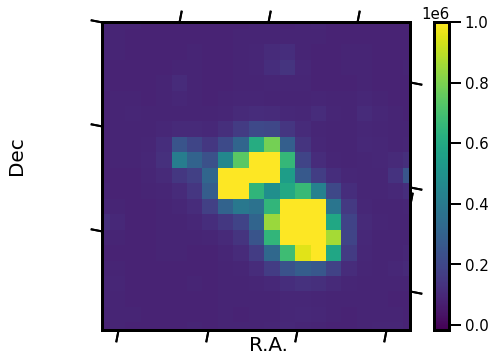

In [119]:
## grab the Lightkruve object. This is for getting the aperture (never got that to work BOOO)
#datalist = lk.search_targetpixelfile("TIC 360156606")
#tes11 = datalist[0].download()


grid = gs.GridSpec(2,2)

fig = plt.figure(figsize=(7,5))
plt.rcParams.update({'font.size': 15})
axes = plt.subplot(projection=wcs)
im = axes.imshow(hdu[0].data, vmax=1e6)#column='FLUX',
           #aperture_mask=tes11.pipeline_mask,scale='log',
           #show_colorbar=True,xlabel=' ',ylabel=' ')
plt.xlabel('')
plt.ylabel('')
axes.set_title('')
plt.colorbar(im)
#axes.set_ylim(961.5,970.5)
#axes.set_xlim(1957.5,1966.5)
fig.text(0, 0.5, 'Dec', ha='center', rotation='vertical', size=20)
fig.text(0.5, 0, 'R.A.', ha='center', size=20);
fig.tight_layout()
plt.xlim(target_x-10,target_x+10)
plt.ylim(target_y-10,target_y+10)
fig.show()

In [121]:
## astroquery. fov/1.75 is not right for most purposes. 
catalogData = Catalogs.query_region(target, radius=1, catalog="Tic")
print('n_targets', len(catalogData))
print('example rows:\n', catalogData[0:5]['ID', 'ra', 'dec','Tmag'])


## I only wanted to mark the stars brighter than the target. 
## Remove this if you want them all. 
catalogData = catalogData[np.where(catalogData['Tmag']<16)]


n_targets 27636
example rows:
     ID           ra              dec          Tmag 
--------- ---------------- ---------------- -------
 15756231  61.331630057213 20.1571009815486  9.4901
 15756232 61.3276161784659 20.1531086298516   15.87
 15756236  61.331494706612 20.1488293842398 13.0924
660130120  61.328171676852 20.1656077945842 19.2293
 15756229 61.3254043218272   20.16506411966 15.6044


In [125]:
# get RA and Dec coords of catalog data
catalogData = catalogData[np.where(catalogData['Tmag']<14)]
tic_ra = catalogData['ra']
tic_dec = catalogData['dec']

# get pixel coordinates of RA and Dec 
coords = wcs.all_world2pix(list(zip(tic_ra, tic_dec)),0)
xc = np.array([c[0] for c in coords])
yc = np.array([c[1] for c in coords])

inds = np.where( (np.abs(np.diff(xc-target_x))<5) &
                 (np.abs(np.diff(yc-target_y))<5) )[0]
xc = xc[inds]
yc = yc[inds]

Set DATE-END to '2021-09-20T13:10:09.220' from MJD-END'. [astropy.wcs.wcs]


(1920.0, 1960.0)

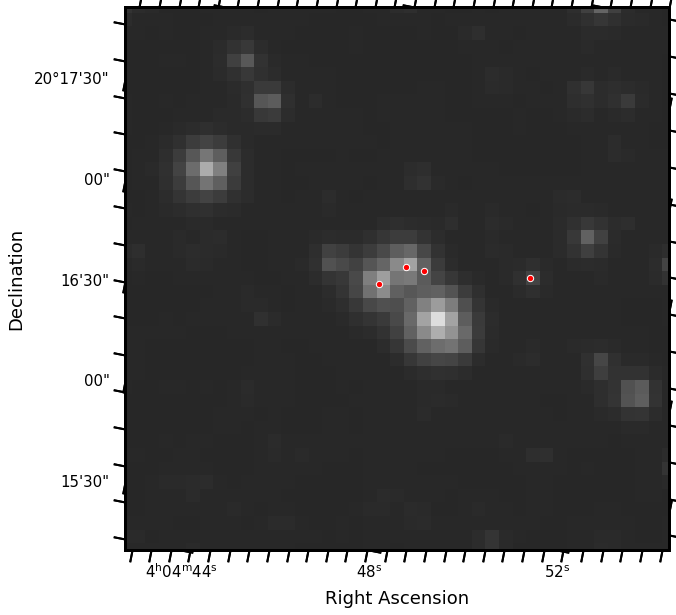

In [246]:
# get first frame of flux from TPF
data = hdu[0].data#[1930:1951,207:228]
norm = simple_norm(data, 'log')
use_wcs = True
wcs = WCS(hdu[0].header)
ax = plt.subplot(projection=wcs)# if use_wcs else None)
ax.imshow(data, origin='lower', norm=norm, cmap='gray')
#ax.scatter(tic_ra, tic_dec, transform=ax.get_transform('world'), s=20, facecolor='red', edgecolor='white')
ax.scatter(xc, yc, s=40, facecolor='red', edgecolor='white')

ax.figure.set_size_inches((10,10))

# deal with axes
if use_wcs:
    xax = ax.coords[0]
    yax = ax.coords[1]
    xax.set_ticks(spacing=1.*u.arcmin)
    yax.set_ticks(spacing=0.5 * u.arcmin)
    xax.set_axislabel('Right Ascension')
    yax.set_axislabel('Declination')
else:
    ax.set_xlabel('x pixel')
    ax.set_ylabel('y pixel')
    
plt.xlim(target_x-20, target_x+20) 
plt.ylim(target_y-20, target_y+20) 
## I did something stupid here. Why does it have a white border?
## Oh I see, I got red dots from sources outside of the range. I need to change the fov thing above. 
## fix later.

(1920.0, 1960.0)

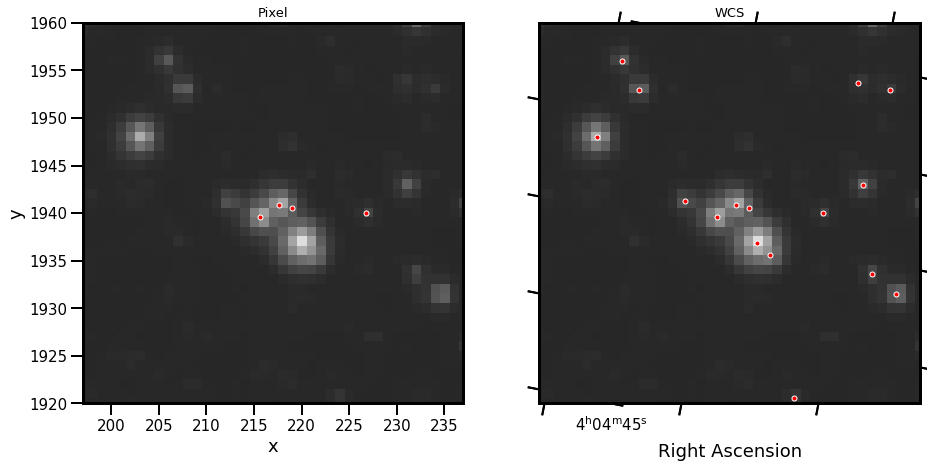

In [247]:
## check pixel vs wcs plot


ax1 = plt.subplot(1,2,1)
ax1.imshow(data, origin='lower', norm=norm,  cmap='gray')
ax1.scatter(xc, yc, s=25, facecolor='red', edgecolor='white')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Pixel')

ax2 = plt.subplot(1,2,2, projection=wcs)
ax2.imshow(data, origin='lower', norm=norm,  cmap='gray')
ax2.coords['ra'].set_axislabel('Right Ascension')
ax2.coords['dec'].set_axislabel('Declination')
ax2.scatter(tic_ra, tic_dec, transform=ax2.get_transform('world'), 
            s=25, facecolor='red', edgecolor='white')
ax2.set_title('WCS')

ax1.figure.set_size_inches((15,15))
ax2.figure.set_size_inches((15,15))

ax1.set_xlim(target_x-20, target_x+20) 
ax1.set_ylim(target_y-20, target_y+20) 

ax2.set_xlim(target_x-20, target_x+20) 
ax2.set_ylim(target_y-20, target_y+20) 

#blah blah white border problem

In [248]:
## Grab the DSS image. There's a better way to do this.
## Use Gagne's finderchart tool to get better images. 
## https://github.com/jgagneastro/finder_charts
## also that way we can get things other than DSS. Could be nice for red sources to use IR surveys
## or faint objects from SDSS, etc. I think Gagne's can get Pan-starrs too. Worth a try. 


## I stole this code from another notebook
## based on the conent, no way I wrote it. 
url = "https://archive.stsci.edu/cgi-bin/dss_search"
plateDict = {"red": "2r", 
             "blue": "2b", 
             "ukred": "poss2ukstu_red", 
             "ukblue": "poss2ukstu_blue"}
def getdss(ra, dec, plate="red", height=None, width=None, 
           filename=None, directory=None):

    """Extract DSS image at position and write a FITS file
    
    ra, dec are J2000 coordinates in degrees
    plate can be "red", "blue", "ukred", or "ukblue"
    height and width are in arcmin, default = 7.0.  Image is square if only one is specified.
    filename specifies name for output file (default="dss_{plate}_{ra}_{dec}.fits")
    directory is location for output file (default is current directory)
    
    Returns the name of the file that was written
    """

    # set defaults for height & width
    if height is None:
        if width is not None:
            height = width
        else:
            height = 8
            width = 8
    elif width is None:
        width = height

    try:
        vplate = plateDict[plate]
    except KeyError:
        raise ValueError("Illegal plate value '{}'\nShould be one of {}".format(
            plate,', '.join(plateDict.keys())))

    # construct filename
    if filename is None:
        filename = "dss_{}_{:.6f}_{:.6f}.fits".format(plate,ra,dec)
    if directory:
        filename = os.path.join(directory, filename)

    params={"r": ra,
            "d": dec,
            "v": vplate,
            "e": "J2000",
            "h": height,
            "w": width,
            "f":"fits",
            "c":"none",
            "s": "yes"}
    r = requests.get(url, params=params)

    # read and format the output
    value = r.content
    if not r.content.startswith(b"SIMPLE  ="):
        raise ValueError("No FITS file returned for {}".format(filename))
    fhout = open(filename, "wb")
    fhout.write(r.content)
    fhout.close()
    return filename

In [249]:
# compute the pixel area in arcmin
arcmin = area.to(u.arcmin).value
# retrieve the DSS file
filename = ['/Users/arcticfox/Downloads/frame-i-004334-6-0131.fits']#
print('DSS Image:', filename)

DSS Image: ['/Users/arcticfox/Downloads/frame-i-004334-6-0131.fits']


In [250]:
dss_data.shape

(600, 600)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set DATE-END to '2021-09-20T13:10:09.220' from MJD-END'. [astropy.wcs.wcs]


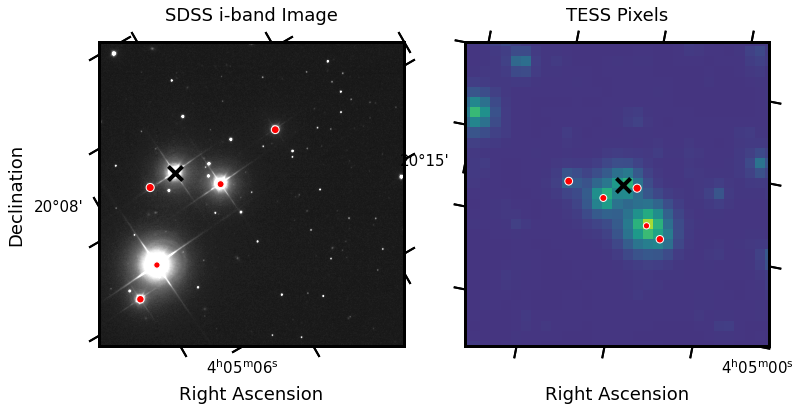

In [335]:
dss = fits.open(filename[0])
# get the data and WCS for the DSS image
dss_data = dss[0].data


# display the DSS image and overlay the objects
ax1 = plt.subplot(1,2,1, projection=WCS(dss[0].header))
im = ax1.imshow(dss_data, origin='lower', vmax=2, cmap='Greys_r')
q = ((tic_ra<61.4) & (tic_ra>61.26) * (tic_dec>20.13) & (tic_dec<20.2))

ax1.scatter(tic_ra[q][1:], 
            tic_dec[q][1:], 
            transform=ax1.get_transform('world'), 
           facecolor='red', edgecolor='white',
           s=catalogData['Tmag'][q][1:]*5,
           zorder=2)
ax1.scatter(tic_ra[q][0], tic_dec[q][0], 
            transform=ax1.get_transform('world'), 
            facecolor='k',marker='x',
            s=200, zorder=4)

ax1.figure.set_size_inches((10,10))
ax1.set_xlabel('Right Ascension')
ax1.set_ylabel('Declination')
ax1.set_title('SDSS i-band Image',y=1.05, fontsize=18)


ax2 = plt.subplot(1,2,2, projection=WCS(hdu[0].header))
ax2.imshow(data,#[target_y-sides:target_y+sides, target_x-sidestarget_x+sides],
           norm=norm)#,origin='upper')


ax2.scatter(tic_ra[q][1:], tic_dec[q][1:], transform=ax2.get_transform('world'), 
                facecolor='red', edgecolor='white', 
                s=catalogData['Tmag'][q][1:]*5)
ax2.scatter(tic_ra[q][0], tic_dec[q][0], transform=ax2.get_transform('world'), 
                facecolor='k',  marker='x', zorder=4,
                s=200)
    
ax2.set_title('TESS Pixels',y=1.05, fontsize=18)
ax2.figure.set_size_inches((12,12))

sides = 15
ax2.set_xlim(target_x-sides, target_x+sides) 
ax2.set_ylim(target_y-sides, target_y+sides) 
ds_sides = 400
ax1.set_xlim(ds_sides-ds_sides, ds_sides+ds_sides) 
ax1.set_ylim(ds_sides-ds_sides, ds_sides+ds_sides) 
ax2.coords['ra'].set_axislabel('Right Ascension')
ax2.coords['dec'].set_axislabel(' ')
ax2.yaxis.tick_right()
#ax.set_xlim(0, 228.5)
#print(ax.get_xlim())

In [330]:
dec

20.157032

In [192]:
# create the function to overlay dss + tesscut + tic catalog
def create_plot(background_img, foreground_img, alpha, norm, wcs, ra, dec):
    ''' create an interactive matplotlib image plot
    
    Parameters:
        background_img (ndarray):
            The background image data to show
        foreground_img (ndarray):
            The foreground image data to overplot. 
        alpha (tuple):
            A tuple of min, max for the interactive slider.  
        norm:
            The image normalization to use for the overlaid image.
        wcs (astropy.wcs.wcs.WCS):
            The WCS of the background image
        ra (list):
            A list of RA coordinate objects
        dec (list):
            A list of Dec coordinate objects
    '''
    # create plot
    ax = plt.subplot(projection=wcs)
    ax.figure.set_size_inches((8,8))

    # show image 1
    ax.imshow(background_img, origin='lower')

    # overlay image 2
    ax.imshow(foreground_img, origin='lower', alpha=alpha, norm=norm, cmap='gray')

    # overlay a list of objects
    ax.scatter(ra, dec, transform=ax.get_transform('world'), s=20, facecolor='red', edgecolor='white')

    # add axis labels
    ax.set_xlabel('Right Ascension')
    ax.set_ylabel('Declination')

In [346]:
# reproject the tesscut onto dss
tpf = data[target_y-10:target_y+10, target_x-10:target_x+10,]

reproj_tesscut, footprint = reproject_interp((data, wcs,), 
                                             dss_wcs, 
                                             shape_out=dss_data.shape, 
                                             order='nearest-neighbor')

dss_data.shape

(1489, 2048)

In [347]:
## some plotting changes that don't suck
plt.rcParams['lines.linewidth']   = 4
plt.rcParams['axes.linewidth']    = 3
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['axes.titlesize']=13

In [348]:
reproj_tesscut.shape

(1489, 2048)

(-0.5, 2047.5) (-0.5, 1488.5)


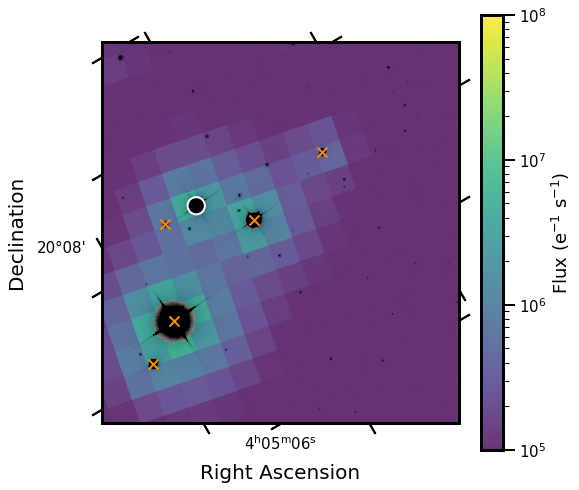

In [404]:
plt.rcParams.update({'font.size': 15})
alpha = 0.6
ax = plt.subplot(projection=dss_wcs)
ax.figure.set_size_inches((8,8))

# show image 1
ax.imshow(dss_data, origin='lower', cmap='Greys',
          vmax=2)

# overlay image 2
img = ax.imshow(reproj_tesscut, origin='lower', 
                alpha=0.8, 
                norm=LogNorm(vmin=1e5, vmax=1e8))

badx, bady = np.where(dss_data<=1)
test = np.copy(dss_data)
test[badx,bady] = np.nan
ax.imshow(test, origin='lower', cmap='Greys',
          vmin=0, vmax=2)#, alpha=0.5)

plt.colorbar(img, ax=ax,label=r'Flux (e$^{-1}$ s$^{-1}$)')
#print(np.min(reproj_tesscut[np.isfinite(reproj_tesscut)]))
#print(np.max(reproj_tesscut[np.isfinite(reproj_tesscut)]))

# overlay all objects
#ax.scatter(tic_ra, tic_dec, transform=ax.get_transform('world'), s=15, facecolor='red', edgecolor='white')

## I decided to just plot the source. The 0.0007 and 0.00015 corrections are the proper motion of the source
## Right way to do this is to check Gaia for the proper motions and multiply by 2016-19XX to the DSS source.
## In some sense it might be nice to plot the Gaia position in that we can do the "see behind" the source trick
## (patient imaging)
ax.scatter(tic_ra[q][1:],#-0.0007, 
           tic_dec[q][1:],#+0.00015,
           marker='x', 
           transform=ax.get_transform('world'), s=100, #facecolors='none', 
           color='darkorange',
           linewidths=2)
ax.scatter(tic_ra[q][0],#-0.0007, 
           tic_dec[q][0],#+0.00015,
           marker='o', 
           transform=ax.get_transform('world'), facecolors='none', 
           edgecolors='w', s=300,
           linewidths=2)
## this is my manual kludge to the aperture. I could never get the lightkurve aperture thing to talk nicely
## with my other plot. So I had to manually try to match. This needs to be fixed. 

#ax.scatter(tic_ra[q],#-0.01, 
#           tic_dec[q],#-0.0015,
#           marker=(4,0,93),
#           transform=ax.get_transform('world'), s=12000, facecolors='none', 
#           edgecolors='r',linewidths=2)

# add axis labels
ax.set_xlabel('Right Ascension',fontsize=20)
ax.set_ylabel('Declination',fontsize=20)
xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.set_xlim(0,750)
ax.set_ylim(0,800)
#plt.set_tight_layout(True)
#plt.savefig('TESSaperture.png',dpi=400,bbox_inches='tight', rasterize=True)

print(xlim,ylim)

In [98]:
tic_ra[0]

61.331630057213